# making a nerual net from scratch

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from typing import Dict,Tuple
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
# setting the decimal number to som fied value
np.set_printoptions(precision=4)

In [4]:
# initialize the weights of the model
def init_weight(input_size:int,
               hidden_sz:int)->Dict[str,np.ndarray]:
    weights:Dict[str,np.ndarray]={}
    weights["w1"]=np.random.randn(input_size,hidden_sz)
    weights["b1"]=np.random.randn(1,hidden_sz)
    weights["w2"]=np.random.randn(hidden_sz,1)
    weights["b2"]=np.random.randn(1,1)
    return weights

In [5]:
def sigmoid(x:np.array)->np.ndarray:
    return 1/(1+np.exp(-x))

In [6]:
def permute_data(x:np.ndarray,
                y:np.ndarray):
    perm=np.random.permutation(x.shape[0])
    return x[perm],y[perm]

In [7]:
batch=Tuple[np.ndarray,np.ndarray]
def generate_batch(x:np.ndarray,
                    y:np.ndarray,
                    start:int=0,
                    batch_sz:int=10
                  )->batch:
    if start+batch_sz > x.shape[0]:
        batch_sz=x.shape[0]- start
    x_batch,y_batch=x[start:start+batch_sz],y[start:start+batch_sz]
    return x_batch,y_batch

In [44]:
def predict(x: np.ndarray, 
            weights: Dict[str, np.ndarray]) -> np.ndarray:
    '''
    Generate predictions from the step-by-step neural network model. 
    '''
    m1 = np.dot(x, weights['w1'])

    n1 = m1 + weights['b1']

    o1 = sigmoid(n1)

    m2 = np.dot(o1, weights['w2'])

    p = m2 + weights['b2']    

    return p

In [47]:
def mae(y_pred:np.ndarray,
       y_true:np.ndarray):
    error=np.mean(np.abs(y_pred-y_true))
    return error

In [48]:
def rmse(y_pred: np.ndarray, y_true: np.ndarray):
 '''
 Compute root mean squared error.
 '''
 return np.sqrt(np.mean(np.power(y_pred - y_true, 2)))

In [8]:
def forward_loss_neural(x:np.ndarray,
                 y:np.ndarray,
                weight:Dict[str,np.ndarray])->Tuple[Dict[str,np.ndarray],float]:

    '''this is the feed forward of a neural network
    ow and this is my first ever nerual network from scratch
    '''

    m1=np.dot(x,weight['w1'])
    n1=m1+weight['b1']
    o1=sigmoid(n1)
    # ENTER THE SECOND LINEAR REGRESSION
    m2=np.dot(o1,weight['w2'])
    p=m2+weight['b2']
    # lets calculate the loss
    loss=np.mean(np.power(y-p,2))
    forward_info:Dict[str,np.ndarray]={}
    forward_info['x']=x
    forward_info['m1']=m1
    forward_info['n1']=n1
    forward_info['o1']=o1
    forward_info['m2']=m2
    forward_info['p']=p
    forward_info['y']=y
    
    return forward_info,loss

In [19]:
# lets make the backpropagation part of the code
def loss_gradient(forward_info:Tuple[Dict[str,np.ndarray],float],
                 weights:Dict[str,np.ndarray])->Dict[str,np.ndarray]:
    dldp=-(forward_info['y']-forward_info['p'])
    dpdm2=np.ones_like(forward_info['m2'])
    #lets drive some derivative out from thees
    dldm2=dldp*dpdm2
    
    dpdb2=np.ones_like(weights['b2'])
    dldb2=(dldp*dpdb2).sum(axis=0)  # sume along the row not the column
    
    dm2dw2=np.transpose(forward_info['o1'],(1,0))
    dldw2=np.dot(dm2dw2,dldp)
    
    dm2do1=np.transpose(weights['w2'],(1,0))
    dldo1=np.dot(dldm2,dm2do1)  # we drive these formula
    
    do1dn1=sigmoid(forward_info['n1']) * (1- sigmoid(forward_info['n1']))
    dldn1=dldo1*do1dn1
    
    dn1dm1=np.ones_like(forward_info['m1'])
    dn1db1=np.ones_like(weights['b1'])
    
    dldb1=(dldn1*dn1db1).sum(axis=0)
    
    dm1dw1=np.transpose(forward_info['x'],(1,0))
    dldw1=np.dot(dm1dw1,dn1dm1)
    
    loss_gradient:Dict[str,np.ndarray]={}
        
    loss_gradient["w2"]=dldw2
    loss_gradient["b2"]=dldb2.sum(axis=0)
    loss_gradient["w1"]=dldw1
    loss_gradient["b1"]=dldb1.sum(axis=0)
    
    return loss_gradient

In [11]:
def init_weight(input_sz:int,
               hidden_sz:int)->Dict[str,np.ndarray]:
    weight:Dict[str,np.ndarray]={}
    weight['w1']=np.random.randn(input_sz,hidden_sz)
    weight['b1']=np.random.randn(1,hidden_sz)
    weight['w2']=np.random.randn(hidden_sz,1)
    weight['b2']=np.random.randn(1,1)
    return weight

In [12]:
def train(x_train:np.ndarray,y_train:np.ndarray,
         x_test:np.ndarray,y_test:np.ndarray,
         n_iter=100,test_every:int=100,
         learning_rate:float=0.01,
         hidden_sz=13,batch_sz:int=100,
         return_losses:bool=False,return_weights:bool=False,return_scores=False,
         seed:int=1)->None:
    if seed:
        np.random.seed(seed)
    start=0  # the starting of the batching of data
    
    # initialize the weight of the data
    weight=init_weight(x_train.shape[1],hidden_sz)

    # lets shuffle the data
    x_train,y_train=permute_data(x_train,y_train)
    losses=[]
    val_score=[]
    # lets train our neural network model
    for i in range(n_iter):
        #lets generate batch for training the weight[neural nets]
        if start >= x_train.shape[0]:
            x_train,y_train=permute_data(x_train,y_train)
            start=0
        x_batch,y_batch=generate_batch(x_train,y_train,start,batch_sz)
        start+=batch_sz
        # the training has began or the feed forward part of the model
        forward_info,loss=forward_loss_neural(x_batch,y_batch,weight)
        # if return losses 
        if return_losses:
            losses.append(loss)
        # and know time for the back propagation
        loss_grad=loss_gradient(forward_info,weight)
        # lets change the parameter after the back propagation
        for key in weight.keys():
            weight[key]-=learning_rate*loss_grad[key]
        # lets test what our model has learned so far
        if return_scores:
            if i%test_every==0  and i!=0:
                y_preds=predict(x_test,weight)
                val_score.append(r2_score(y_preds,y_test))  
    if return_weights:
        return losses,weight,val_score
    return None

# lets make a data set ready for training

In [13]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

In [14]:
s=StandardScaler()
data=s.fit_transform(data)

In [15]:
x_train,x_test,y_train,y_test=train_test_split(data,target,random_state=42)

In [16]:
y_train=y_train.reshape(-1,1)
y_test=y_test.reshape(-1,1)

In [17]:
y_train.shape,y_test.shape

((379, 1), (127, 1))

# lets train our nerual net 

In [30]:
test_nn=True
if test_nn:
    num_iter = 10000
    test_every = 1000
    train_info = train(x_train, y_train, x_test, y_test,
                       n_iter=num_iter,
                       test_every = test_every,
                       learning_rate = 0.001,
                       batch_sz=23, 
                       return_losses=True, 
                       return_weights=True, 
                       return_scores=False,
                       seed=80718)
    losses = train_info[0]
    weights = train_info[1]
    val_scores = train_info[2]

In [31]:
losses

[596.6673909831941,
 310.17696635701805,
 326.35902732720575,
 258.85442719264125,
 211.8764535782331,
 308.39092476781906,
 187.75260675958683,
 47.169206089773425,
 81.14044264180932,
 85.3613932389154,
 80.98275671311696,
 127.51144608756127,
 97.23349099990283,
 38.16861551646331,
 48.186611797376166,
 99.19125512655839,
 90.55303579525305,
 70.18049066347947,
 97.61110881791487,
 51.81318287166399,
 83.39212272336738,
 61.67256148414511,
 74.94882375243034,
 41.618026235918535,
 38.46092665456415,
 79.97617464387474,
 107.47628833052674,
 61.13087307767056,
 160.9362531634961,
 91.2025743953026,
 90.13127280425947,
 71.00928327930701,
 90.19323660683116,
 293.2072410728637,
 71.6617451628038,
 121.27681916494086,
 158.8573456598283,
 70.10664620297965,
 54.85440114593813,
 110.81036331867357,
 40.347644248977716,
 90.43253787422333,
 103.66803570693683,
 48.87958877885284,
 65.03515946067374,
 94.43825775783124,
 56.7891983112184,
 60.41174429170772,
 85.43564956414293,
 85.046286

In [23]:
weights

{'w1': array([[  3.7487,   3.7369,   4.612 ,   4.474 ,   3.5942,   2.8079,
           4.9538,   2.6345,   3.0154,   2.8985,   3.3441,   3.9197,
           2.6171],
        [ -1.6522,  -1.2284,  -0.6516,  -3.1662,  -2.921 ,  -1.5001,
          -3.5059,  -0.1681,  -3.0238,  -3.854 ,  -0.5935,  -2.4789,
          -2.5641],
        [  1.3174,   1.0634,  -0.4614,   0.543 ,   0.2254,  -0.2205,
           0.798 ,   0.2719,   1.9611,   0.943 ,  -0.206 ,  -0.0244,
           1.2631],
        [ -6.5114,  -7.4452,  -7.2679,  -6.587 ,  -6.3648,  -7.4398,
          -6.8682,  -6.0664,  -5.9149,  -7.8997,  -9.2541,  -5.9257,
          -7.7042],
        [ -5.6246,  -7.8982,  -6.518 ,  -5.6982,  -7.3457,  -6.4867,
          -6.7275,  -7.1995,  -7.0116,  -8.8711,  -5.3463,  -8.5022,
          -8.    ],
        [-12.3486, -12.2948, -11.7216, -12.0517, -11.6075, -13.4348,
         -11.0906, -12.3265, -12.4227, -11.6537, -12.0313, -12.789 ,
         -13.0878],
        [ -6.2077,  -3.7407,  -5.7509,  -5.646

In [32]:
val_scores

[]

In [33]:
weights['w2']

array([[  1.7273],
       [ -7.7782],
       [ -4.8095],
       [ 12.8432],
       [  2.5828],
       [ -5.9843],
       [  2.9109],
       [  5.3377],
       [-18.2165],
       [  1.739 ],
       [ -4.5065],
       [  3.4047],
       [ -1.5523]])

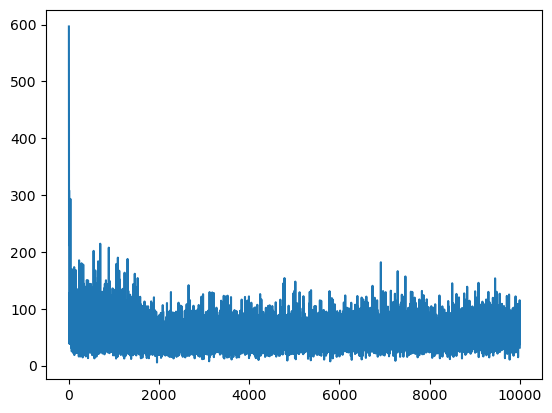

In [34]:
plt.plot(list(range(10000)), losses);

In [45]:
preds = predict(x_test, weights)

In [46]:
preds

array([[31.9176],
       [32.1895],
       [19.8878],
       [19.8878],
       [19.8878],
       [19.8878],
       [19.8878],
       [19.8878],
       [19.8878],
       [19.8878],
       [32.1895],
       [ 7.9749],
       [19.8878],
       [19.8878],
       [19.8878],
       [19.8878],
       [19.8878],
       [19.8878],
       [32.1895],
       [19.8878],
       [19.8878],
       [19.9008],
       [19.8878],
       [19.8878],
       [19.8878],
       [19.8878],
       [19.8878],
       [19.8878],
       [23.0739],
       [19.8878],
       [19.8853],
       [19.8878],
       [19.8878],
       [19.8878],
       [19.8878],
       [32.1895],
       [32.0013],
       [19.8878],
       [27.6329],
       [19.8878],
       [19.8878],
       [30.1503],
       [32.1895],
       [19.8878],
       [19.9664],
       [19.8878],
       [19.8878],
       [19.8878],
       [19.8878],
       [32.1895],
       [25.6427],
       [32.1895],
       [19.8878],
       [19.8878],
       [32.1895],
       [19

In [49]:
# evaluating the error of the network
print("Mean absolute error:", round(mae(preds, y_test), 4), "\n"
      "Root mean squared error:", round(rmse(preds, y_test), 4))

Mean absolute error: 5.0984 
Root mean squared error: 6.9477
